# TP1 : EDP

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import matplotlib as mpl
import time
import scipy.stats as stats
import pandas as pd

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

mpl.rcParams['figure.dpi'] = 125

# Explicit Euler

N = 10 I =  9 SCHEME = EE


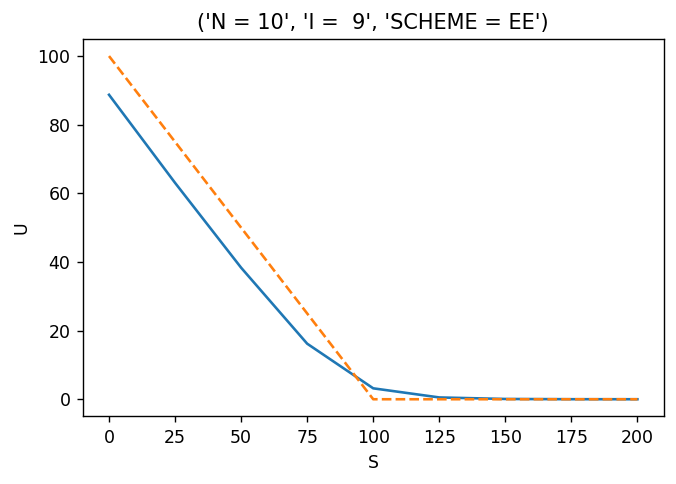

In [49]:
import numpy as np

    
def stabilityTable(scheme, s, Ns, Is):

    Us = []
    tcpus = []
    hs = []

    for I in Is:
        N = I
        ee = SchemePrice(N, I, scheme)
        U = ee.interpolate(s)
        Us.append(U)
        hs.append(ee.h)
        tcpus.append(ee.tcpu)


    df = pd.DataFrame({'I': Is, 'N': Ns, 'U(s)': Us})
    df['error'] = np.abs(df['U(s)'].shift() - df['U(s)'])
    df['h'] = hs
    df['alpha'] = np.log(df['error'].shift()/df['error'])/np.log(df['h'].shift()/df['h'])
    df['errex'] = np.abs(df['U(s)'] - ee.blackScholes(s))
    df['tcpu'] = tcpus

    return df


class SchemePrice:
    def __init__(self, N, I, scheme = "EE"):
        self.N = N
        self.I = I
        self.K = 100
        self.Smin = 0
        self.Smax = 200
        self.T = 1
        self.sigma = 0.2
        self.r = 0.1
        self.h = (self.Smax - self.Smin)/(self.I + 1)
        self.dt = self.T/self.N
        self.S = np.linspace(self.Smin, self.Smax, self.I)
        self.time = np.arange(0, self.T, self.dt)
        self.A = self.createA()
        self.U = None
        self.U0 = self.u0(self.S)
        self.SCHEME = scheme
        self.title = 'N =%3i'%self.N,'I =%3i'%self.I,'SCHEME = %s'%self.SCHEME
        self.mu = (self.dt/self.h**2)*self.sigma**2*self.Smax**2
        self.tcpu = 0
                            
    
    def plot(self):
        self.checkSolved()
        plot(self.S, self.U)
        plot(self.S, self.U0, linestyle="--")
        plt.title(self.title)
        plt.xlabel("S")
        plt.ylabel("U")
        plt.show()
    
    def checkSolved(self):
        if self.U == None:
            self.U = self.solve()
    
    def Ind(self, a, b, x):
        return np.where((a <= x) & (x <= b), 1, 0)

    def u0(self, s):
        return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)

    def uleft(self, t):
        return self.K * np.exp(-self.r * t) - self.Smin

    def uright(self, t):
        return 0

    def s(self, j):
        return self.Smin + j * self.h

    def alpha(self, j):
        return self.sigma**2 * self.s(j)**2 / (2 * self.h**2)

    def beta(self, j):
        return self.r * self.s(j) / (2 * self.h)
    
    def interpolate(self, s):
        self.checkSolved()
        s_index = np.argmax(self.S > s)
        return ((self.S[s_index+1] - s)/self.h * self.U[s_index] + (s - self.S[s_index])/self.h * self.U[s_index + 1])[0]

    def createA(self):
        A = np.zeros((self.I, self.I))
        for i in range(1, self.I+1):
            A[i-1][i-1] = 2 * self.alpha(i) + self.r
            if i < self.I:
                A[i-1][i] = -self.alpha(i) - self.beta(i)
            if i > 1:
                A[i-1][i-2] = -self.alpha(i) + self.beta(i)
        return A

    def q(self, t):
        y = np.zeros((self.I, 1))
        y[0] = (-self.alpha(1) + self.beta(1)) * self.uleft(t)
        y[self.I-1] = (-self.alpha(self.I) + self.beta(self.I)) * self.uright(t)
        return y

    def createU(self):
        U = np.zeros(self.I)
        for i in range(self.I):
            U[i] = self.u0(self.S[i])
        return U.reshape(self.I, 1)
    
    def blackScholes(self, sbar):
        dplus=(np.log(sbar/self.K)+self.r+0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        dmoins=(np.log(sbar/self.K)+self.r-0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        vbar=np.exp(-self.r*self.T)*self.K*stats.norm.cdf(-dmoins)-sbar*stats.norm.cdf(-dplus)
        return vbar

    def solve(self):
        t0 = time.time()
        print('N =%3i'%self.N,'I =%3i'%self.I,'SCHEME = %s'%self.SCHEME)
        
        A = self.A
        U = self.createU()
        
        if self.SCHEME == "EE":
            for n in range (self.N):
                U = U - self.dt * (A@U + self.q(self.time[n]))
            
        elif self.SCHEME == "IE":
            for n in range (self.N):
                U = np.linalg.solve(np.identity(self.I) + self.dt * A, - self.dt * self.q(self.time[n]) + U)    
        elif self.SCHEME == "CR":
            tetha=0.5
            for n in range (self.N):   
                F = - (tetha * self.q(self.time[n]) + (1 - tetha) * self.q(self.time[n-1]))
                part1 = U - (1 - tetha) * self.dt * (A@U)
                U= np.linalg.solve(np.identity(self.I) + tetha * self.dt * A, self.dt * F + part1)
            
        self.U = U
        self.tcpu = time.time() - t0
        return U

SchemePrice(10, 9).plot()

## Numerical tests

### a)

N = 10 I = 10 SCHEME = EE


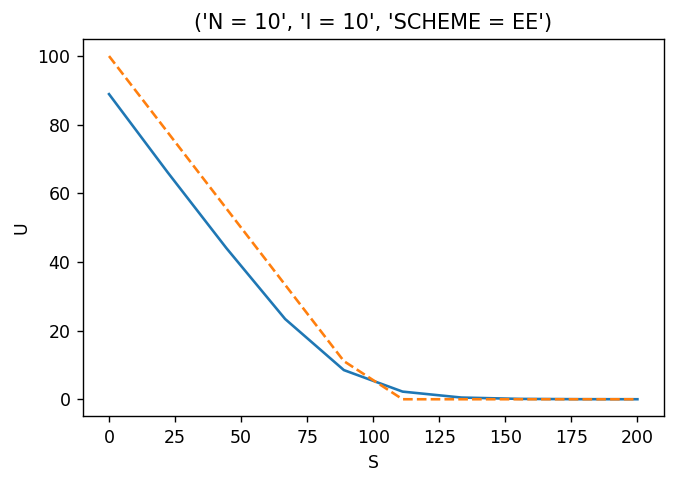

N = 10 I = 20 SCHEME = EE


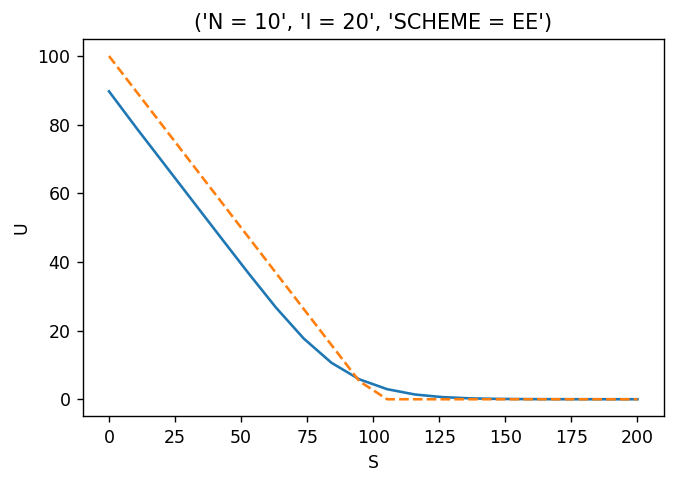

N = 10 I = 50 SCHEME = EE


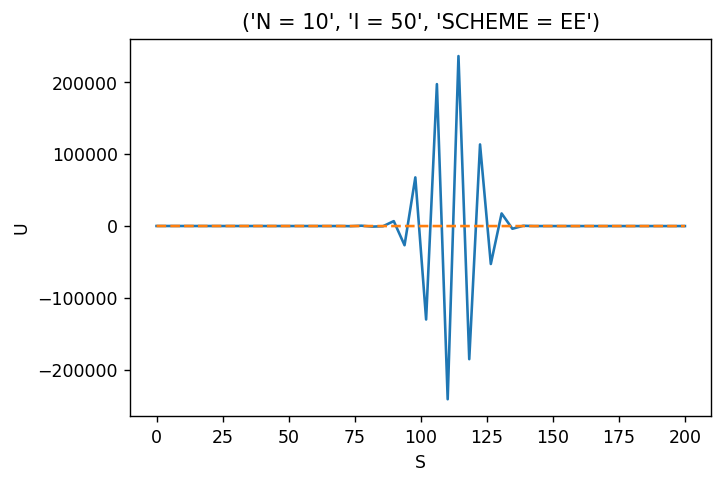

In [50]:
N = 10
Is = [10, 20, 50]

for i in Is:
    I = i
    SchemePrice(N, I).plot()

N = 10 I = 10 SCHEME = EE


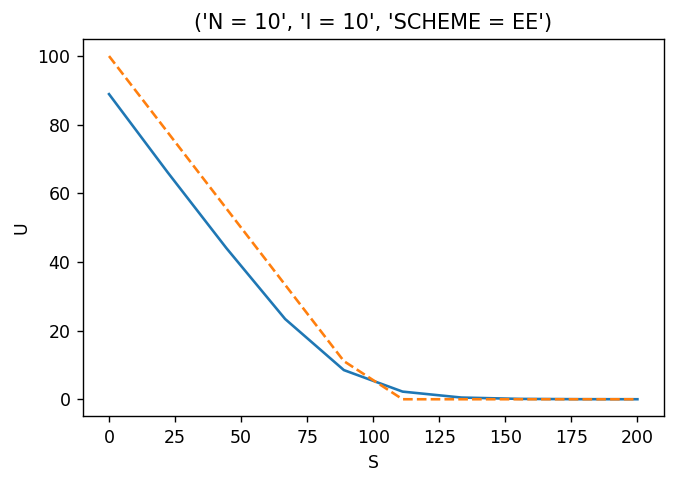

N = 20 I = 20 SCHEME = EE


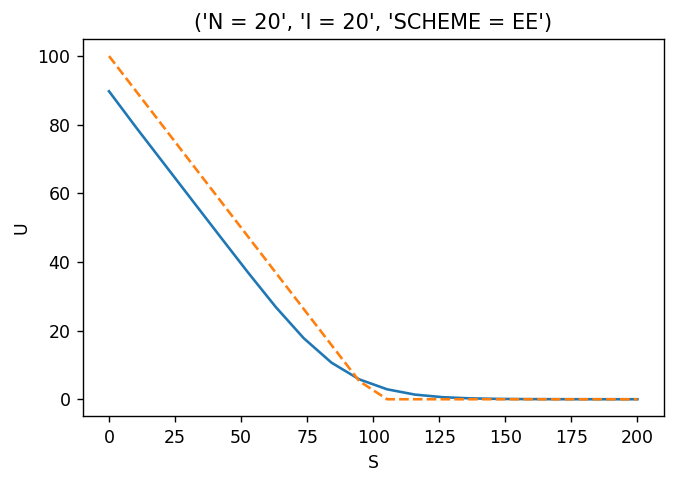

N = 50 I = 50 SCHEME = EE


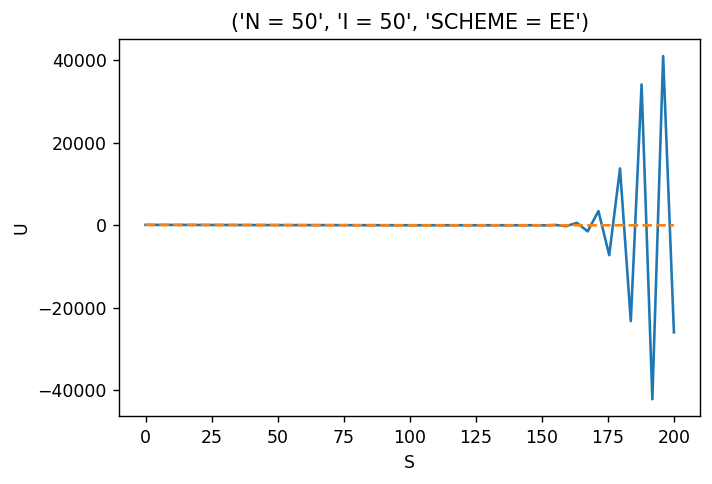

N =100 I =100 SCHEME = EE


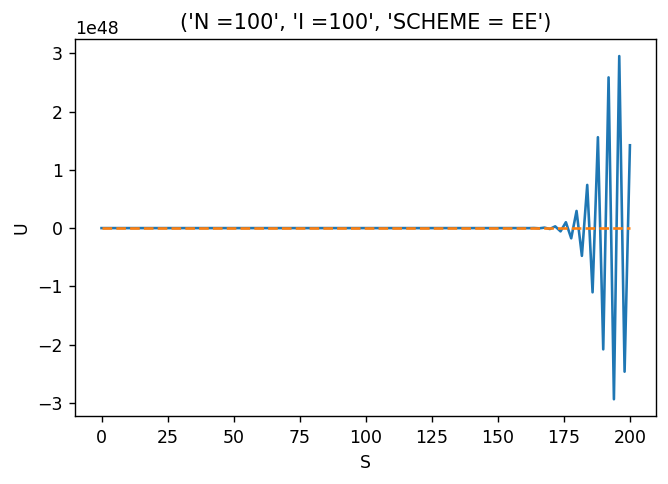

In [51]:
Is = [10, 20, 50, 100]
for i in Is:
    I = i
    N = i
    SchemePrice(N, I).plot()

### b)

In [52]:
N = 10
I = 50

ee = SchemePrice(N, I)
A = ee.A
B = np.eye(I) - ee.dt*A

print("B : ", B)

B :  [[ 9.860e-01  7.000e-03  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]
 [-2.000e-03  9.740e-01  1.800e-02 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  3.000e-03  9.540e-01 ...  0.000e+00  0.000e+00  0.000e+00]
 ...
 [ 0.000e+00  0.000e+00  0.000e+00 ... -8.226e+00  4.848e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00 ...  4.557e+00 -8.614e+00  5.047e+00]
 [ 0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  4.750e+00 -9.010e+00]]


In [53]:
print("Nombre de valeurs de B négatives : ", len(B[np.where(B < 0)]))
print("Nombre de valeurs de B positives : ", len(B[np.where(B > 0)]))
print("Nombre de valeurs de B > 1 : ", len(B[np.where(np.abs(B) > 1)]))
print("Norme infinie :", np.linalg.norm(B, np.inf))
print("Norme 2 :", np.linalg.norm(B, 2))

Nombre de valeurs de B négatives :  36
Nombre de valeurs de B positives :  112
Nombre de valeurs de B > 1 :  83
Norme infinie : 18.218000000000004
Norme 2 : 16.473976044293302


In [54]:
N = 10
I = 10

ee = SchemePrice(N, I)
A = ee.A
B = np.eye(I) - ee.dt*A

print("B : ", B)

B :  [[ 0.986  0.007  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.002  0.974  0.018  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.003  0.954  0.033  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.012  0.926  0.052  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.025  0.89   0.075  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.042  0.846  0.102  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.063  0.794  0.133  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.088  0.734  0.168  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.117  0.666  0.207]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.15   0.59 ]]


In [55]:
print("Nombre de valeurs de B négatives : ", len(B[np.where(B < 0)]))
print("Nombre de valeurs de B positives : ", len(B[np.where(B > 0)]))
print("Nombre de valeurs de B > 1 : ", len(B[np.where(np.abs(B) > 1)]))
print("Norme infinie :", np.linalg.norm(B, np.inf))
print("Norme 2 :", np.linalg.norm(B, 2))

Nombre de valeurs de B négatives :  1
Nombre de valeurs de B positives :  27
Nombre de valeurs de B > 1 :  0
Norme infinie : 0.994
Norme 2 : 0.9869154650871313


## c)

In [56]:
NIs = [(10, 10), (10, 50)]

for N, I in NIs:
    
    print(f"Mu for I = {I}, N = {N} is {SchemePrice(N, I).mu}")

Mu for I = 10, N = 10 is 0.484
Mu for I = 50, N = 10 is 10.404000000000003


## d)

In [57]:
N = 10
I = 10
print(SchemePrice(N, I).interpolate(90))

N = 10 I = 10 SCHEME = EE
4.723717791325948


## e)

In [58]:
stabilityTable("EE", 80, [10, 20, 40, 80, 160, 320], [10, 20, 40, 80, 160, 320])

N = 10 I = 10 SCHEME = EE
N = 20 I = 20 SCHEME = EE
N = 40 I = 40 SCHEME = EE
N = 80 I = 80 SCHEME = EE
N =160 I =160 SCHEME = EE
N =320 I =320 SCHEME = EE


,I,N,U(s),error,h,alpha,errex,tcpu
0,10,10,1.344761e+01,NaN,18.181818,NaN,1.739473e-01,0.000000
1,20,20,1.392629e+01,4.786827e-01,9.523810,NaN,6.526300e-01,0.001506
2,40,40,1.374366e+01,1.826286e-01,4.878049,1.440227,4.700015e-01,0.001007
3,80,80,-1.807802e+05,1.807940e+05,2.469136,-20.275927,1.807935e+05,0.001002
4,160,160,-1.263532e+71,1.263532e+71,1.242236,-220.701928,1.263532e+71,0.018100
5,320,320,NaN,NaN,0.623053,NaN,NaN,0.033154


In [59]:
Is = [10, 20, 40, 80, 160, 320]
Ns = np.array(Is)**2/10
stabilityTable("EE", 80, Ns, Is)

N = 10 I = 10 SCHEME = EE
N = 20 I = 20 SCHEME = EE
N = 40 I = 40 SCHEME = EE
N = 80 I = 80 SCHEME = EE
N =160 I =160 SCHEME = EE
N =320 I =320 SCHEME = EE


,I,N,U(s),error,h,alpha,errex,tcpu
0,10,10.0,1.344761e+01,NaN,18.181818,NaN,1.739473e-01,0.000000
1,20,40.0,1.392629e+01,4.786827e-01,9.523810,NaN,6.526300e-01,0.000000
2,40,160.0,1.374366e+01,1.826286e-01,4.878049,1.440227,4.700015e-01,0.001002
3,80,640.0,-1.807802e+05,1.807940e+05,2.469136,-20.275927,1.807935e+05,0.001002
4,160,2560.0,-1.263532e+71,1.263532e+71,1.242236,-220.701928,1.263532e+71,0.016609
5,320,10240.0,NaN,NaN,0.623053,NaN,NaN,0.033684


# Implicit Euler

## a)

N = 10 I = 50 SCHEME = IE


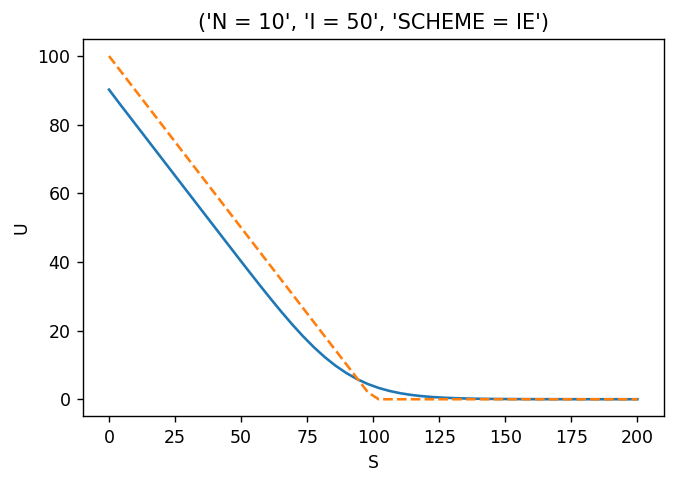

In [60]:
N = 10
I = 50

SchemePrice(N, I, "IE").plot()

## b)

In [61]:
Is = [10, 20, 40, 80, 160, 320]
Ns = np.array(Is)/10
stabilityTable("IE", 80, Ns, Is)

N = 10 I = 10 SCHEME = IE
N = 20 I = 20 SCHEME = IE
N = 40 I = 40 SCHEME = IE
N = 80 I = 80 SCHEME = IE
N =160 I =160 SCHEME = IE
N =320 I =320 SCHEME = IE


,I,N,U(s),error,h,alpha,errex,tcpu
0,10,1.0,13.641668,NaN,18.181818,NaN,0.368005,0.000000
1,20,2.0,14.067949,0.426282,9.523810,NaN,0.794287,0.002999
2,40,4.0,13.812959,0.254990,4.878049,0.768066,0.539296,0.019531
3,80,8.0,13.575958,0.237001,2.469136,0.107453,0.302295,0.096353
4,160,16.0,13.432412,0.143546,1.242236,0.729900,0.158749,0.499106
5,320,32.0,13.354851,0.077561,0.623053,0.892105,0.081188,2.616874


# Crank Nicolson

## a)

N = 10 I = 50 SCHEME = CR


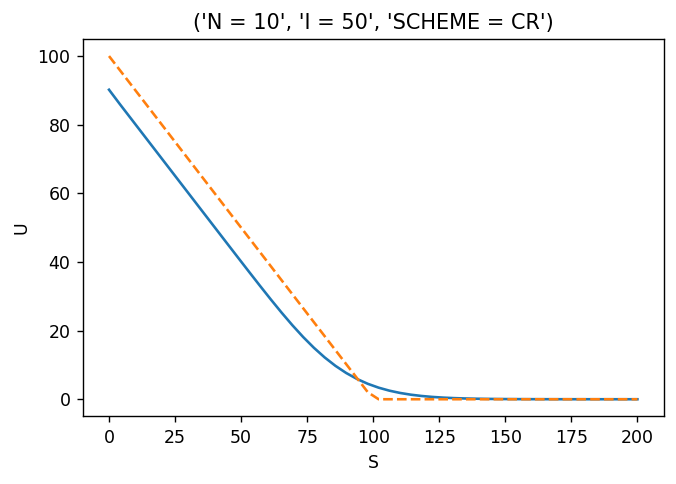

In [62]:
N = 10
I = 50

SchemePrice(N, I, "CR").plot()

## b)

In [63]:
Is = [10, 20, 40, 80, 160, 320]
Ns = np.array(Is)/10
stabilityTable("CR", 80, Ns, Is)

N = 10 I = 10 SCHEME = CR
N = 20 I = 20 SCHEME = CR
N = 40 I = 40 SCHEME = CR
N = 80 I = 80 SCHEME = CR
N =160 I =160 SCHEME = CR
N =320 I =320 SCHEME = CR


,I,N,U(s),error,h,alpha,errex,tcpu
0,10,1.0,13.544259,NaN,18.181818,NaN,0.270596,0.002001
1,20,2.0,13.995668,0.451409,9.523810,NaN,0.722005,0.004207
2,40,4.0,13.778073,0.217596,4.878049,1.090703,0.504410,0.018612
3,80,8.0,13.559042,0.219031,2.469136,-0.009651,0.285379,0.092681
4,160,16.0,13.424066,0.134976,1.242236,0.704720,0.150403,0.521548
5,320,32.0,13.350699,0.073367,0.623053,0.883477,0.077036,2.183023
